# Rag From Scratch: Indexing
- Indexing不同的索引优化策略
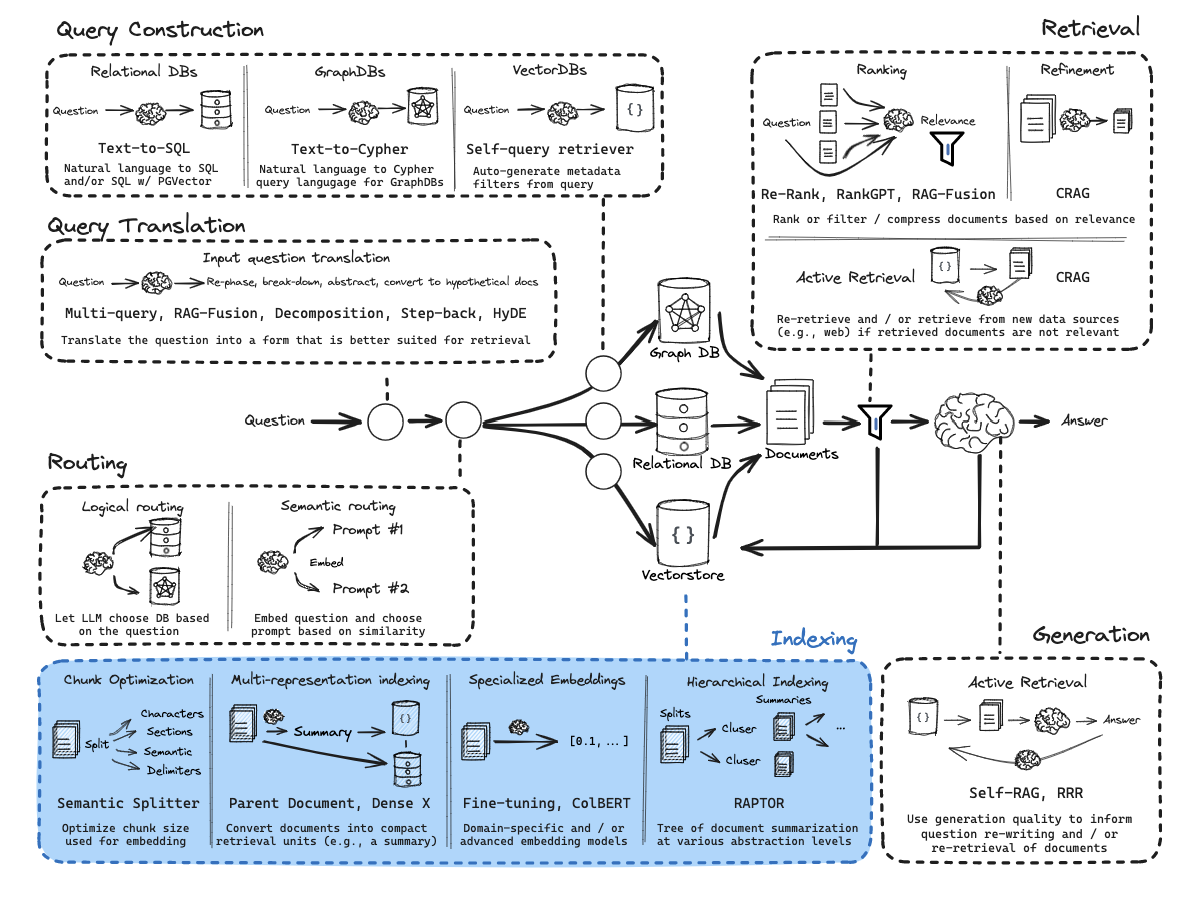

## Preface: Chunking
We don't explicity cover document chunking / splitting.

For an excellent review of document chunking, see this video from Greg Kamradt:

https://www.youtube.com/watch?v=8OJC21T2SL4

文档索引问题：许多RAG方法侧重于将文档分割成块，并在LLM检索时返回相关的一部分块。然而，块大小和块数量是很难设置好的参数；如果返回的块不包含回答问题的所有上下文，则两者都会显著地影响结果。

解决思路：针对检索优化，使用LLM生成文档摘要。在此基础上，我们创建了两种检索器：
- （1）multi-vector retriever将摘要向量化，但将完整文档返给LLM。
- （2） parent-doc retriever将块向量化，但将完整文档返给LLM。
核心思想是使用较小/简洁的表示（摘要或块）进行检索，但将它们链接到完整的文档/上下文中进行生成。

## Enviornment

In [2]:
! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain youtube-transcript-api pytube

In [3]:
import os
from dotenv import find_dotenv, load_dotenv
_ = load_dotenv(find_dotenv())


os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'

langchain_api_key=os.environ['langchain_api_key']

In [4]:
zhipu_api_key = os.environ['ZHIPUAI_API_KEY']

## Part 12: Multi-representation Indexing（多层表达索引）

- 多层表达索引: ，通过将原始数据生成 summary后重新作为embedding再存到summary database中。 索引的话首先通过summary database找到最相关summary最回溯到原始文档中去。

在长上下文环境比较有用。

FLow:
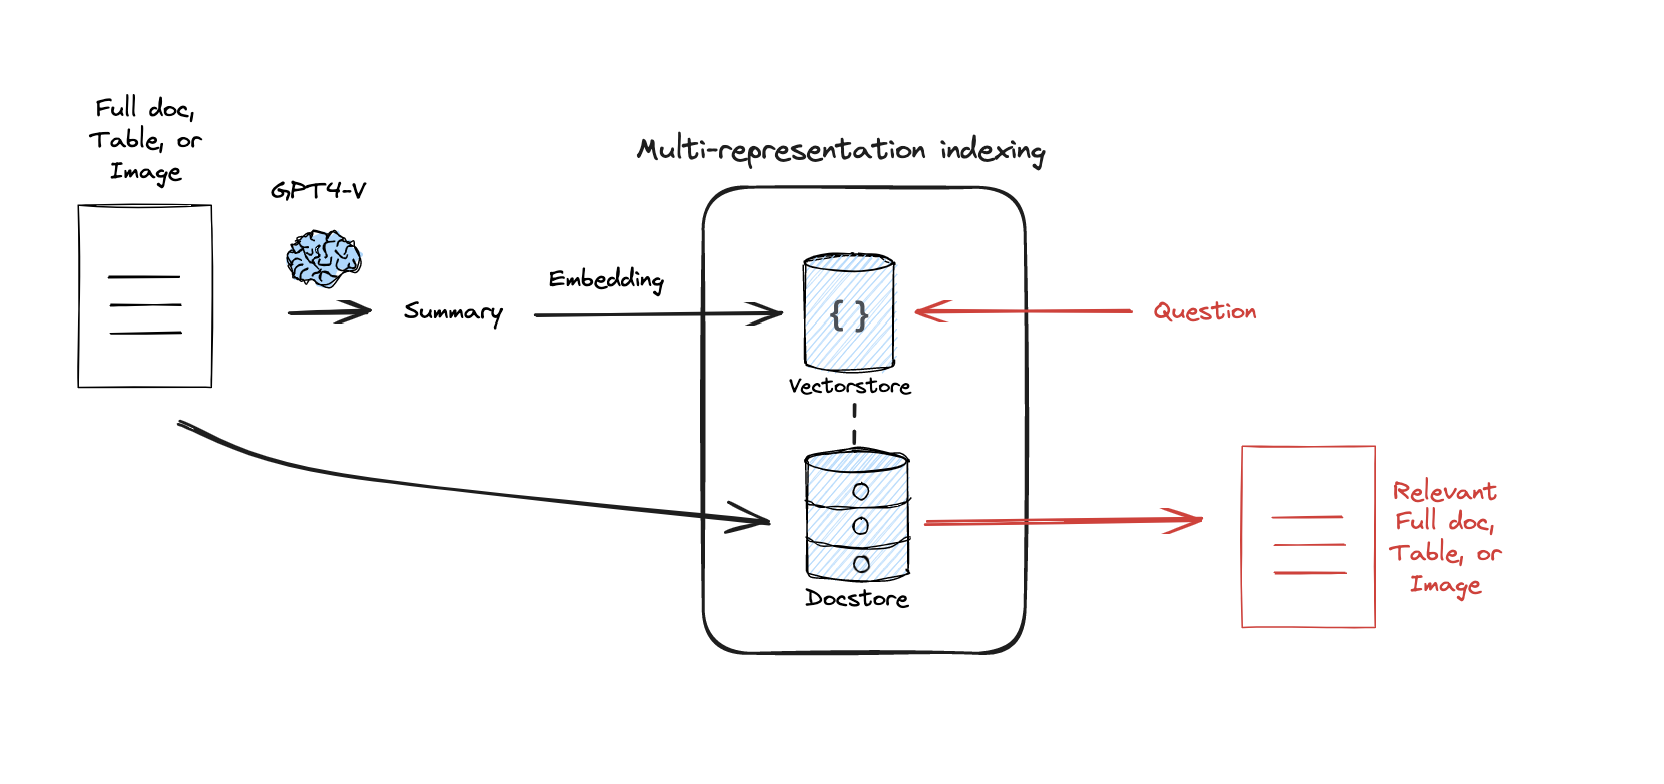

Docs:

https://blog.langchain.dev/semi-structured-multi-modal-rag/

https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector

Paper:

https://arxiv.org/abs/2312.06648

In [9]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

loader = WebBaseLoader("https://lilianweng.github.io/posts/2024-02-05-human-data-quality/")
docs.extend(loader.load())

In [10]:
import uuid

from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.chat_models import ChatZhipuAI

llm = ChatZhipuAI(model='glm-3-turbo', api_key=zhipu_api_key)

# 为文档生成摘要
chain = (
    {'doc': lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
    | llm 
    | StrOutputParser()
)

summaries = chain.batch(docs, {"max_concurrency": 5})

In [11]:
summaries

['The article provides an extensive overview of LLM-powered autonomous agents. It breaks down the components of such agents into planning, memory, and tool use, discussing various methods and frameworks used to enhance the capabilities of large language models (LLMs) in these areas. The author also discusses limitations such as the restricted context capacity of LLMs, the challenges in long-term planning and task decomposition, and the reliability of natural language interfaces. Overall, the article serves as a comprehensive guide to understanding how LLMs can be used to create autonomous agents and the current state of research in this field.',
 'The blog post "Thinking about High-Quality Human Data" written by Lilian Weng on February 5, 2024, explores the significance and methods of obtaining high-quality data from human annotators for deep learning model training. The author begins by stating the general consensus within the community about the value of high-quality data, yet there 

多向量检索器（MultiVectorRetriever）允许每个文档存储多个向量


- 向量存储：使用Chroma进行向量的存储。
- 文档存储：使用InMemoryByteStore进行文档的存储。
- 检索器初始化：使用MultiVectorRetriever进行初始化，设置好文档和向量存储。


In [12]:
from langchain.storage import InMemoryByteStore
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.retrievers.multi_vector import MultiVectorRetriever


# 使用向量库去存储文档快（child chunks）
emb_model_path ="D:/code/models/M3E/xrunda/m3e-base/"
vectorstores = Chroma(collection_name='summaries',
                     embedding_function=HuggingFaceEmbeddings(model_name=emb_model_path))

# 使用InMemoryByteStore存储原始文档（parent documents）
store = InMemoryByteStore()
id_key = "doc_id"

# 检索
retrievers = MultiVectorRetriever(
    vectorstores=vectorstores,
    byte_store=store,
    id_key=id
)
doc_ids = [str(uuid.uuid4()) for _ in docs]

# Docs linked tosummaries
summary_docs = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(summaries)
]

# Add
retrievers.vectorstores.add_documents(summary_docs)
retrievers.docstore.mset(list(zip(doc_ids, docs)))

C:\Users\houhailun\AppData\Local\Temp\ipykernel_26988\1981343238.py:10: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  embedding_function=HuggingFaceEmbeddings(model_name=emb_model_path))
C:\Users\houhailun\AppData\Local\Temp\ipykernel_26988\1981343238.py:9: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the langchain-chroma package and should be used instead. To use it run `pip install -U langchain-chroma` and import as `from langchain_chroma import Chroma`.
  vectorstores = Chroma(collection_name='summaries',


ValidationError: 2 validation errors for MultiVectorRetriever
vectorstore
  field required (type=value_error.missing)
id_key
  str type expected (type=type_error.str)

## PART 13: RAPTOR

### 问题
在传统的 RAG 中，我们通常会依赖于检索短文本块。但当处理需要理解长篇上下文的文档时，简单的将文档切割或仅处理其上下文显然不够。这就需要一种更合理的长文档处理方法，RAPTOR 应运而生

### RAPTOR是什么？
递归抽象处理树组织检索（Recursive Abstractive Processing for Tree Organized Retrieval）是一种全新且强大的技术，用于以全面的方式对大型语言模型（LLM）进行索引和检索。它采用自下而上的方法，通过对文本段（块）进行聚类和总结，形成一个层级的树状结构

### RAPTOR的论文介绍了一种有趣的索引和检索文档的方法：
- 叶子代表起始文档。
- 叶子被嵌入并进行聚类。
- 然后将聚类总结成更高层次（更抽象）的信息整合，涵盖了类似文档。
- 通过递归执行这个过程，最终形成从原始文档（叶子）到更抽象总结的“树”。

这个方法可以在不同规模上应用，叶子可以是：
- 单个文档的文本块（如论文所展示）
- 完整文档（如我们下面所展示）
使用更长的上下文 LLM，可以对完整文档执行此操作。

RAPTOR 的树状结构是其功能的核心，因为它能够捕捉到文本的高层次和细节方面，这对于处理复杂的主题查询和问答任务中的多步推理特别有价值。

此过程包括将文档分割成称为块的短文本，然后使用嵌入模型对这些块进行处理。接下来，这些嵌入将被聚类算法处理。一旦形成了聚类，就使用大型语言模型（LLM）对每个聚类关联的文本进行总结。

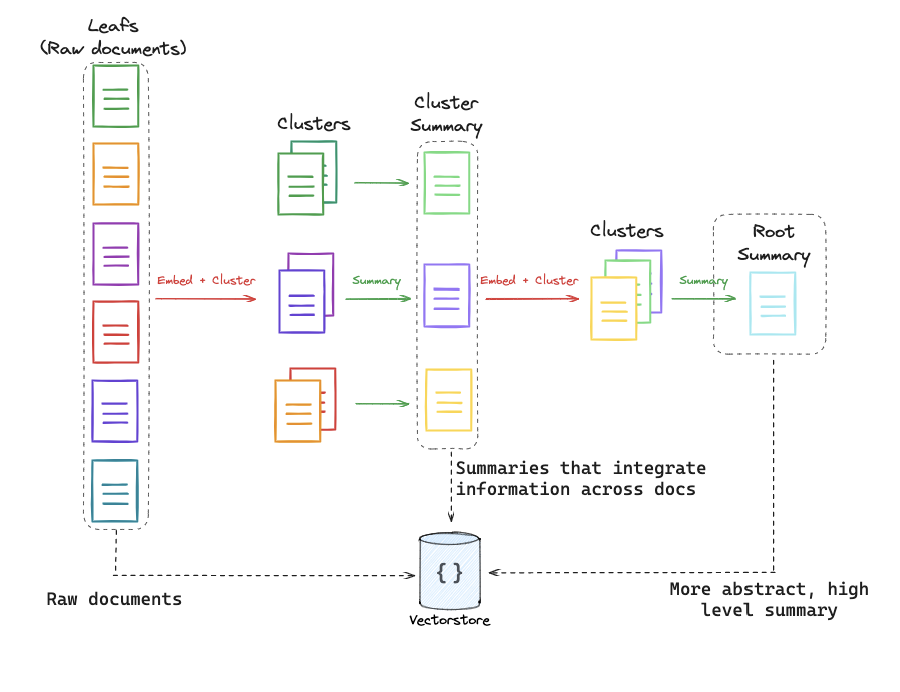

### 简单来说，RAPTOR 的核心思想包括：
- 对相似文档进行聚类和总结。
- 将相关文档的信息汇总到一个总结中。
- 在需要较少上下文信息就能回答的问题上提供帮助。

Deep dive video:

https://www.youtube.com/watch?v=jbGchdTL7d0

Paper:

https://arxiv.org/pdf/2401.18059.pdf

Full code:

https://github.com/langchain-ai/langchain/blob/master/cookbook/RAPTOR.ipynb

In [13]:
pip install -U langchain umap-learn scikit-learn langchain_community tiktoken langchain-openai langchainhub langchain-chroma langchain-anthropic

  Using cached langchain-0.3.0-py3-none-any.whl.metadata (7.1 kB)
  Using cached langchain_openai-0.2.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached langchain_text_splitters-0.3.0-py3-none-any.whl.metadata (2.3 kB)
Using cached langchain-0.3.0-py3-none-any.whl (1.0 MB)
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB ? eta -:--:--
   --- ------------------------------------ 1.0/11.0 MB 3.1 MB/s eta 0:00:04
   --------- ------------------------------ 2.6/11.0 MB 5.6 MB/s eta 0:00:02
   --------- ------------------------------ 2.6/11.0 MB 5.6 MB/s eta 0:00:02
   --------- ------------------------------ 2.6/11.0 MB 5.6 MB/s eta 0:00:02
   --------- ------------------------------ 2.6/11.0 MB 5.6 MB/s eta 0:00:02
   ------------ --------------------------- 3.4/11.0 MB 2.4 MB/s eta 0:00:04
   ------------- -------------------------- 3.7/11.0 MB 2.3 MB/s eta 0:00:04
   -------------- ------------------------- 3.

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-experimental 0.0.62 requires langchain-community<0.3.0,>=0.2.6, but you have langchain-community 0.3.0 which is incompatible.
langchain-experimental 0.0.62 requires langchain-core<0.3.0,>=0.2.10, but you have langchain-core 0.3.5 which is incompatible.


In [16]:
import matplotlib.pyplot as plt
import tiktoken
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader  # 递归网页爬取

<function matplotlib.pyplot.show(close=None, block=None)>

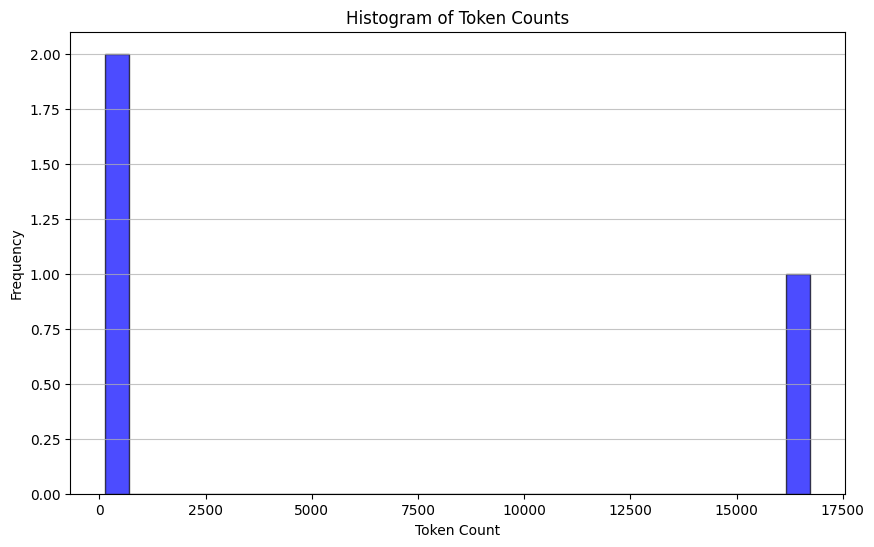

In [19]:
def num_tokens_from_string(string: str, encoding_name:str) -> int:
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


# LCEL docs
url = "https://python.langchain.com/docs/expression_language/"
loader = RecursiveUrlLoader(
    url=url, max_depth=2, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# LCEL w/ PydanticOutputParser (outside the primary LCEL docs)
url = "https://python.langchain.com/docs/modules/model_io/output_parsers/quick_start"
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs_pydantic = loader.load()

# LCEL w/ Self Query (outside the primary LCEL docs)
url = "https://python.langchain.com/docs/modules/data_connection/retrievers/self_query/"
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs_sq = loader.load()

# Doc texts
docs.extend([*docs_pydantic, *docs_sq])
docs_texts = [d.page_content for d in docs]

# # Calculate the number of tokens for each document
counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]

# Plotting the histogram of token counts
# 通过计算每篇文档的词元数量并用直方图展示，来检查我们的原始文档大小。
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# Display the histogram
plt.show

In [20]:
len(docs_texts)

3

In [24]:
# 检查所有文档是否在大型语言模型的上下文窗口内

# Doc texts concat
d_sorted = sorted(docs, key=lambda x: x.metadata['source'])
d_reversed = list(reversed(d_sorted))

concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content, "cl100k_base")
)

Num tokens in all context: 17008


In [23]:
docs[0].metadata

{'source': 'https://python.langchain.com/docs/expression_language/',
 'content_type': 'text/html; charset=utf-8',
 'title': 'Conceptual guide | ğŸ¦œï¸�ğŸ”— LangChain',
 'description': 'This section contains introductions to key parts of LangChain.',
 'language': 'en'}

In [34]:
# 将文档分块，以便它们适应大型语言模型的上下文窗口。
from langchain_text_splitters import RecursiveCharacterTextSplitter

chunk_size_top = 2000
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size_top,
    chunk_overlap=0
)
texts_split = text_splitter.split_text(concatenated_content)

In [35]:
len(texts_split)

12

### Model

In [28]:
from langchain_community.chat_models import ChatZhipuAI
from langchain_community.embeddings import HuggingFaceEmbeddings

llm = ChatZhipuAI(api_key=zhipu_api_key, model='glm-3-turbo')

emb_model_path ="D:/code/models/M3E/xrunda/m3e-base/"
embd = HuggingFaceEmbeddings(model_name=emb_model_path)

生成全局嵌入列表

In [36]:
# 它包含了每个块的语义意义嵌入。

global_embeddings = [embd.embed_query(txt) for txt in texts_split]

print(len(global_embeddings[0]))


768


## Part 14: ColBERT

- Contextual Late Interactions BERT

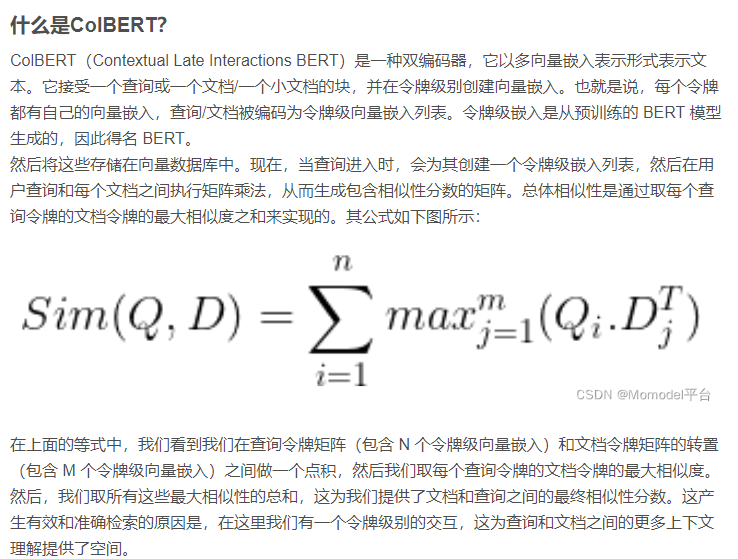

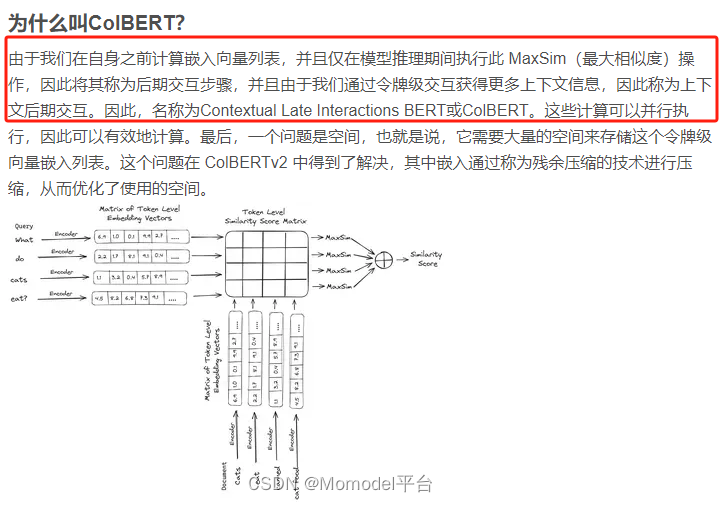

RAGatouille使ColBERT的使用变得简单。

ColBERT为段落中的每个标记生成一个受上下文影响的向量。

ColBERT同样为查询中的每个标记生成向量。

然后，每个文档的得分是每个查询嵌入与任何文档嵌入的最大相似度之和：

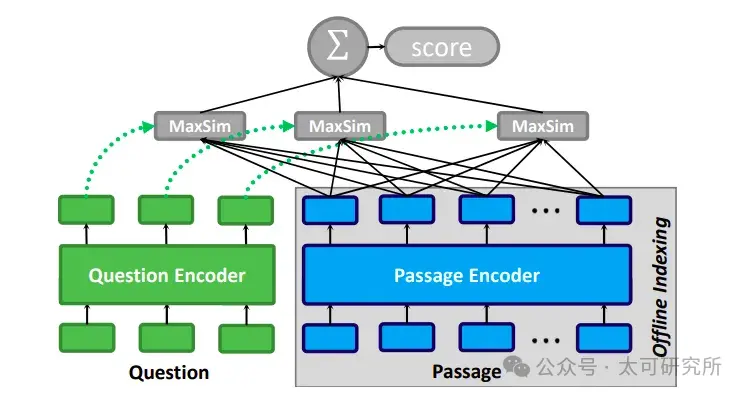


- 计算流程
    - 左右两边分别是 Question 文本和原始文档 Passage 文本，分别经过自己的 Encoder 编码出来一组向量。
    - 这两组向量再两两计算一下相似度，最后再求和就得到一个分数，就是 Question 和 Passage 的距离分数；
    - Question 文本和数据库中的每一篇文档都计算一个相似度分数，如此就可以对分数进行排序，分数越低说明越相似，这就是 ColBERT 的计算流程。
   
- 优势
    - 文档和查询可以使用不同的 Embedding 模型，意味着文档可以使用基础模型进行预处理；
    - 可以将文档中 token 上下文关系带入到距离计算中；
    - 可以兼顾语义搜索和关键词搜索。

In [37]:
! pip install ragatouille

# RAGatouille：该库使我们能够以易于使用的方式使用最先进的 （SOTA） 检索方法，例如ColBERT。它提供了在数据集上创建索引、查询索引的选项，甚至允许我们在数据上训练 ColBERT 模型。

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.6 MB ? eta -:--:--
   --------------------------------- ------ 1.3/1.6 MB 3.5 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 3.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 1.2/1.2 MB 10.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 9.9 MB/s eta 0:00:00
  Created wheel for colbert-ai: filename=colbert_ai-0.2.19-py3-none-any.whl size=114798 sha256=85da40d5a715f3703a10ad268cfaf9701170736eeaa3ddd21ed118f764bed652
  Stored in directory: c:\users\houhailun\appdata\local\pip\cache\wheels\90\b9\63\d4fc276c73c42ef7fc1065a26cf87e5a1cf56ef6498cbfbe5d
Successfully built colbe

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
label-studio-converter 0.0.58 requires nltk==3.6.7, but you have nltk 3.9.1 which is incompatible.
volcengine 1.0.146 requires pytz==2020.5, but you have pytz 2022.7.1 which is incompatible.


In [40]:
# 下载预训练模型

# from ragatouille import RAGPretrainedModel
# RAG = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

from modelscope.hub.snapshot_download import snapshot_download

model_name = "jinaai/jina-colbert-v2"
model_dir = snapshot_download(model_name, cache_dir='D:\code\models\colbert2')

2024-09-23 10:40:14,819 - modelscope - INFO - PyTorch version 2.1.2 Found.
2024-09-23 10:40:14,823 - modelscope - INFO - Loading ast index from C:\Users\houhailun\.cache\modelscope\ast_indexer
2024-09-23 10:40:15,006 - modelscope - INFO - Loading done! Current index file version is 1.14.0, with md5 9a106def0ca5ace3dd2f1a371a9431e7 and a total number of 976 components indexed
Downloading: 100%|████████████████████████████████████████████████████████████████| 1.19k/1.19k [00:00<00:00, 1.22MB/s]
Downloading: 100%|████████████████████████████████████████████████████████████████████████| 1.54k/1.54k [00:00<?, ?B/s]
Downloading: 100%|██████████████████████████████████████████████████████████████████████████| 64.0/64.0 [00:00<?, ?B/s]
Downloading: 100%|████████████████████████████████████████████████████████████████| 3.92M/3.92M [00:01<00:00, 2.32MB/s]
Downloading:  52%|█████████████████████████████████▌                              | 1.09G/2.08G [19:37<14:44, 1.20MB/s]2024-09-23 11:03:24,241

In [ ]:
from ragatouille import RAGPretrainedModel

colbert_model_path = 'D:\code\models\colbert2\jinaai\jina-colbert-v2'
RAG = RAGPretrainedModel.from_pretrained(colbert_model_path)

In [41]:
# 下载一个维基百科页面并从中执行检索
import requests

def get_wikipedia_page(title):
    """接收字符串并获取相应的维基百科页面。
    """
    # Wikipedia API endpoint
    URL = "https://en.wikipedia.org/w/api.php"

    # Parameters for the API request
    params = {
        "action": "query",
        "format": "json",
        "titles": title,
        "prop": "extracts",
        "explaintext": True,
    }
    
    # Custom User-Agent header to comply with Wikipedia's best practices
    headers = {"User-Agent": "RAGatouille_tutorial/0.0.1 (ben@clavie.eu)"}

    response = requests.get(URL, params=params, headers=headers)
    data = response.json()

    # Extracting page content
    page = next(iter(data["query"]["pages"].values()))
    return page["extract"] if "extract" in page else None

full_document = get_wikipedia_page("习近平")

ConnectTimeout: HTTPSConnectionPool(host='en.wikipedia.org', port=443): Max retries exceeded with url: /w/api.php?action=query&format=json&titles=%E4%B9%A0%E8%BF%91%E5%B9%B3&prop=extracts&explaintext=True (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001F077835CC0>, 'Connection to en.wikipedia.org timed out. (connect timeout=None)'))

In [ ]:
full_document

In [ ]:
# 为文档创建索引
RAG.index(
    collection=[full_document],
    index_name='习近平-123'，
    max_document_length=180,  # Chunk Size of the Document Chunks
    split_document=True
)

# 参数说明：
# 收集：这是我们要索引的文档列表。在这里，我们只有一个文档，因此是一个文档的列表。
# document_ids：每个文档都需要一个唯一的文档 ID。在这里，我们将其命名为elon_musk，因为该文件是关于埃隆·马斯克（Elon Musk）的。
# document_metadatas：每个文档都有其元数据。这又是一个字典列表，其中每个字典都包含特定文档的键值对元数据。
# index_name：我们正在创建的索引的名称。我们将其命名为 Elon2。
# max_document_size： 这与块大小类似。我们指定每个文档块应该有多少。在这里，我们给它的值是 256。如果我们不指定任何值，则 256 将作为默认块大小。
# split_documents：它是一个布尔值，其中 True 表示我们要根据给定的块大小拆分文档，而 False 表示我们希望将整个文档存储为单个块。

In [ ]:
# 检索
retriever = RAG.as_langchain_retriever(k=3)
retriever.invoke("习主席是从哪一年担任主席的？")